# Go/No-Go Task Intermediate Preprocessing Pipeline

This notebook demonstrates how to use the intermediate preprocessing pipeline for Go/No-Go task data. The intermediate pipeline builds upon the minimal preprocessing steps and performs more advanced artifact correction using ICA and AutoReject.

## Pipeline Overview

The intermediate preprocessing pipeline includes the following steps:
1. **Load Preprocessed Data**: Load epoched data from the minimal pipeline
2. **First AutoReject Pass**: Identify bad epochs from the minimal preprocessing output
3. **ICA Extraction**: Compute ICA components from good epochs
4. **ICA Labeling**: Identify and remove artifact components (eye, muscle, heart)
5. **Second AutoReject Pass**: Apply a second AutoReject step to cleaned data
6. **Save Results**: Save the fully cleaned epochs for further analysis
7. **Visualization**: Generate summary plots of the preprocessed data

## Setting Up the Environment

First, let's import the necessary libraries and configure the environment.

In [12]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import mne
import yaml
from pathlib import Path
import logging
import importlib

# Add the parent directory to path to import custom modules
sys.path.append(os.path.abspath('../..'))

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger('gonogo_intermediate_preprocessing')

# MNE settings
mne.set_log_level('INFO')
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the Pipeline Configuration

We'll load the intermediate pipeline configuration from the YAML file.

In [13]:
# Try to load the intermediate pipeline configuration, fall back to minimal if not found
config_path = '../../configs/gonogo_intermediate_pipeline.yml'
if not os.path.exists(config_path):
    config_path = '../../configs/gonogo_minimal_pipeline.yml'
    logger.warning(f"Intermediate pipeline config not found, using minimal pipeline config: {config_path}")

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
print(f"Loaded configuration from {config_path}")

# Extract key configuration parameters
root_dir = config['directory']['root']
processed_dir = os.path.join(root_dir, config['directory']['processed_dir'])

# Create a paths object for standardized file paths
from scr.steps.project_paths import ProjectPaths
paths = ProjectPaths(config)

# Get default parameters from config
sub_id = config.get('default_subject', '01')
ses_id = config.get('default_session', '001')
run_id = config.get('default_run', '01')
task_id = "gng"

# Define output directory structure
figures_dir = os.path.join(processed_dir, "figures")
os.makedirs(figures_dir, exist_ok=True)

# Define specific figure directories
autoreject_dir = os.path.join(figures_dir, f"sub-{sub_id}", f"ses-{ses_id}", "autoreject")
ica_extraction_dir = os.path.join(figures_dir, f"sub-{sub_id}", f"ses-{ses_id}", "ica", "extraction")
ica_labeling_dir = os.path.join(figures_dir, f"sub-{sub_id}", f"ses-{ses_id}", "ica", "labeling")
summary_dir = os.path.join(figures_dir, f"sub-{sub_id}", f"ses-{ses_id}", "summary")

# Create specific directories
os.makedirs(autoreject_dir, exist_ok=True)
os.makedirs(ica_extraction_dir, exist_ok=True)
os.makedirs(ica_labeling_dir, exist_ok=True)
os.makedirs(summary_dir, exist_ok=True)

# Debugging mode (faster processing with simplified parameters)
debug_mode = config.get('debug_mode', {}).get('enabled', False)
if debug_mode:
    logger.info("Running in DEBUG mode with faster processing settings")

2025-04-14 20:22:35,831 - gonogo_intermediate_preprocessing - INFO - Running in DEBUG mode with faster processing settings


Loaded configuration from ../../configs/gonogo_intermediate_pipeline.yml


## Step 1: Loading Preprocessed Data

First, we need to load the preprocessed epochs from the minimal pipeline output.

In [14]:
# Define the expected input file path
input_file = os.path.join(
    processed_dir, 
    f"sub-{sub_id}", 
    f"ses-{ses_id}", 
    f"sub-{sub_id}_ses-{ses_id}_task-{task_id}_run-{run_id}_preprocessed-epoched.fif"
)

# Check if the file exists
if not os.path.isfile(input_file):
    # Try to find any epoched files if exact format doesn't exist
    import glob
    base_dir = os.path.join(processed_dir, f"sub-{sub_id}", f"ses-{ses_id}")
    pattern = os.path.join(base_dir, f"sub-{sub_id}_ses-{ses_id}_*epo*.fif")
    matching_files = glob.glob(pattern)
    
    if matching_files:
        # Sort by modification time (most recent first)
        matching_files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
        input_file = matching_files[0]
        logger.info(f"Using alternative file: {input_file}")
    else:
        raise FileNotFoundError(f"No epoched files found in {base_dir}. Please run the minimal preprocessing pipeline first.")

# Load the preprocessed epochs
logger.info(f"Loading preprocessed epochs from: {input_file}")
try:
    # Try to load directly as epochs
    epochs = mne.read_epochs(input_file, preload=True)
    logger.info("Successfully loaded epochs directly")
except Exception as e:
    logger.warning(f"Error loading epochs directly: {e}. Trying alternative approach...")
    # Try loading as raw and create epochs
    try:
        raw = mne.io.read_raw_fif(input_file, preload=True)
        # Check if raw has events
        if hasattr(raw, 'events'):
            events = raw.events
            event_id = raw.event_id if hasattr(raw, 'event_id') else None
            epochs = mne.Epochs(raw, events, event_id=event_id, tmin=-0.2, tmax=0.8, 
                               baseline=(None, 0), preload=True)
        else:
            # If no events, create fixed-length epochs
            events = mne.find_events(raw)
            if len(events) > 0:
                epochs = mne.Epochs(raw, events, tmin=-0.2, tmax=0.8, 
                                   baseline=(None, 0), preload=True)
            else:
                events = mne.make_fixed_length_events(raw, duration=2.0)
                epochs = mne.Epochs(raw, events, tmin=0, tmax=2.0, 
                                   baseline=None, preload=True)
        logger.info("Successfully created epochs from raw data")
    except Exception as e2:
        raise RuntimeError(f"Failed to load the data: {e2}")

# Display basic information about the loaded epochs
print("\nLoaded epochs information:")
print(f"Number of epochs: {len(epochs)}")
print(f"Number of channels: {len(epochs.ch_names)}")
print(f"Time range: {epochs.tmin:.2f} to {epochs.tmax:.2f} seconds")
if hasattr(epochs, 'event_id') and epochs.event_id:
    print(f"Event types: {epochs.event_id}")
else:
    print("No event types found in the data")

# Plot the epochs
epochs.plot(n_epochs=5, title='Loaded preprocessed epochs')

2025-04-14 20:22:43,758 - gonogo_intermediate_preprocessing - INFO - Loading preprocessed epochs from: D:/Yann/neurotheque_resources/data/processed\sub-01\ses-001\sub-01_ses-001_task-gng_run-01_preprocessed-epoched.fif


Reading D:\Yann\neurotheque_resources\data\processed\sub-01\ses-001\sub-01_ses-001_task-gng_run-01_preprocessed-epoched.fif ...
    Found the data of interest:
        t =    -200.00 ...    1000.00 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
396 matching events found
No baseline correction applied
0 projection items activated


C:\Users\s\AppData\Local\Temp\ipykernel_35376\1447488746.py:29: RuntimeWarning: This filename (D:/Yann/neurotheque_resources/data/processed\sub-01\ses-001\sub-01_ses-001_task-gng_run-01_preprocessed-epoched.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(input_file, preload=True)
2025-04-14 20:22:43,814 - gonogo_intermediate_preprocessing - INFO - Successfully loaded epochs directly



Loaded epochs information:
Number of epochs: 396
Number of channels: 20
Time range: -0.20 to 1.00 seconds
Event types: {'correct_go': 11, 'correct_nogo': 21}


## Step 2: First AutoReject Pass

We'll now apply AutoReject to identify bad epochs from the minimal preprocessing output.

2025-04-14 20:49:09,119 - gonogo_intermediate_preprocessing - INFO - Applying AutoReject to identify bad epochs
2025-04-14 20:49:09,127 - root - INFO - [AutoRejectStep] Data type: <class 'mne.epochs.EpochsFIF'>
2025-04-14 20:49:09,127 - root - INFO - [AutoRejectStep] Is instance of mne.Epochs: False
2025-04-14 20:49:09,128 - root - INFO - [AutoRejectStep] Switching matplotlib backend from inline to TkAgg for interactive plotting
2025-04-14 20:49:09,129 - root - WARNING - [AutoRejectStep] Could not switch to interactive backend: Cannot load backend 'TkAgg' which requires the 'tk' interactive framework, as 'qt' is currently running
2025-04-14 20:49:09,130 - root - WARNING - [AutoRejectStep] Interactive plots may not work properly
2025-04-14 20:49:09,130 - root - INFO - [AutoRejectStep] Using existing epochs for AutoReject.
2025-04-14 20:49:09,131 - root - INFO - [AutoRejectStep] Running AutoReject with params: {'n_interpolate': None, 'consensus': None, 'thresh_method': 'bayesian_optimiza

Data shape before AutoReject: (396, 20, 361) (epochs x channels x time points)
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/19 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/19 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/396 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/396 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/396 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/396 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4


2025-04-14 20:50:07,070 - root - INFO - [AutoRejectStep] Running in 'fit' mode - only identifying bad epochs
2025-04-14 20:50:07,077 - root - INFO - [AutoRejectStep] Data already in epochs format. Bad epochs stored in data.info['temp']['autoreject_bad_epochs']
2025-04-14 20:50:07,078 - root - INFO - [AutoRejectStep] Found 55 bad epochs out of 396
2025-04-14 20:50:07,079 - root - INFO - [AutoRejectStep] AutoReject identified 55 bad epochs out of 396 (13.9%)


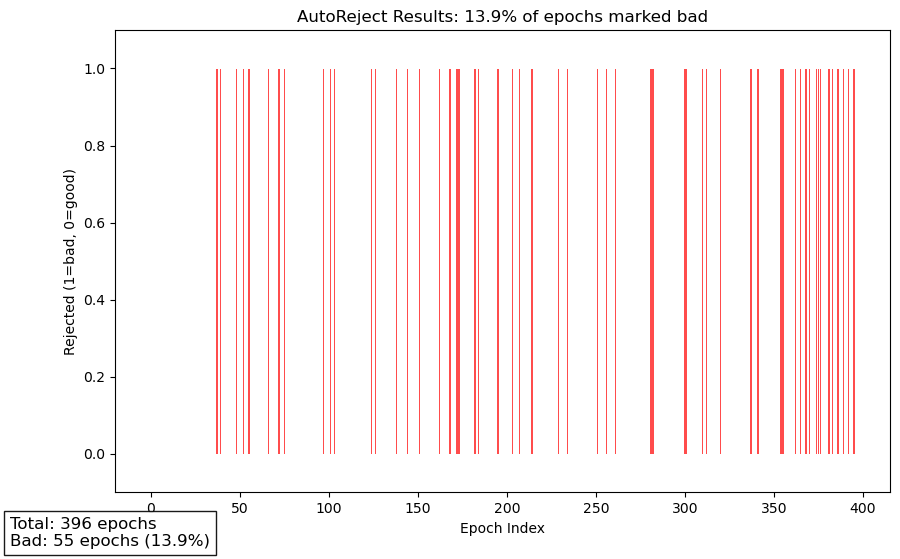

2025-04-14 20:50:07,623 - root - WARNING - [AutoRejectStep] Error creating thresholds visualization: 0
2025-04-14 20:50:07,625 - root - INFO - [AutoRejectStep] Excluding trigger/stim channels from rejection plot: ['Trigger']


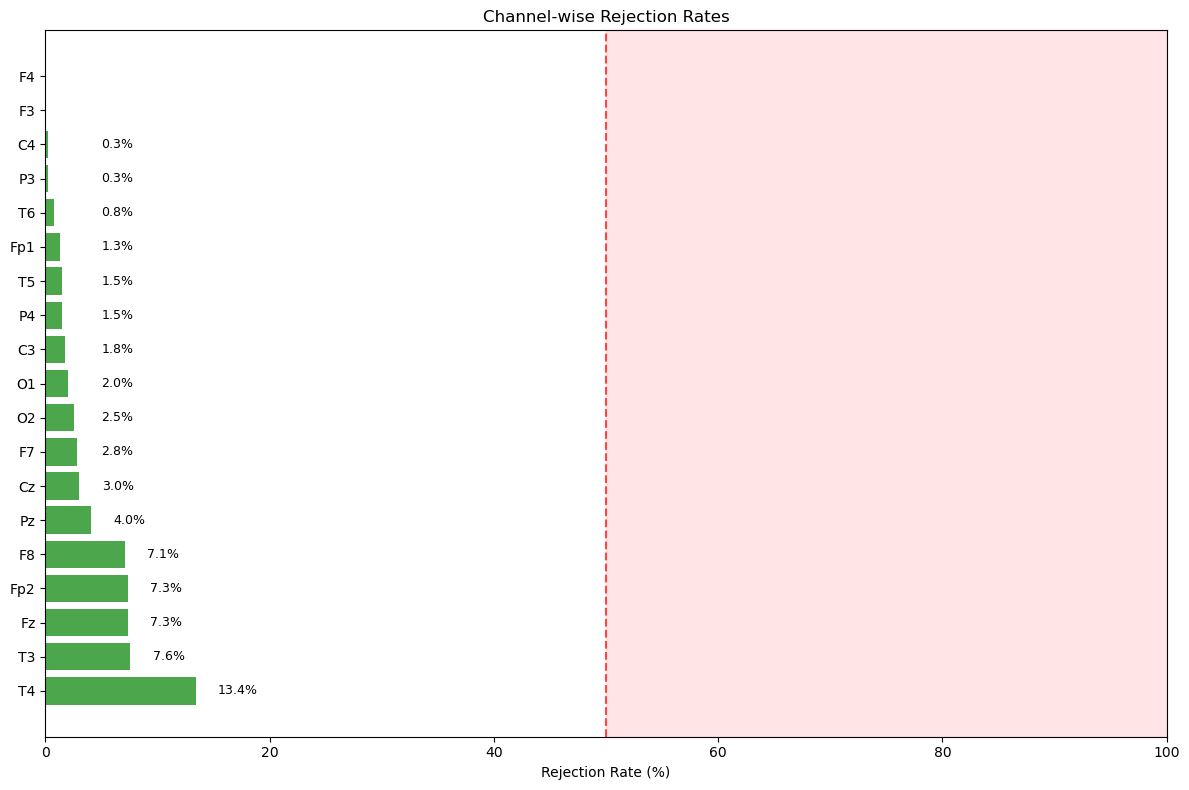

2025-04-14 20:50:07,998 - root - INFO - [AutoRejectStep] Saved channel rejection rates visualization to D:/Yann/neurotheque_resources/data/processed\figures\sub-01\ses-001\autoreject
2025-04-14 20:50:07,999 - root - INFO - [AutoRejectStep] Stored AutoReject information in data.info['temp']
2025-04-14 20:50:07,999 - root - INFO - [AutoRejectStep] Bad epochs: 55 out of 396
2025-04-14 20:50:08,001 - root - INFO - [AutoRejectStep] VERIFICATION: Found 55 bad epochs in info['temp']
2025-04-14 20:50:08,002 - root - INFO - [AutoRejectStep] Switching matplotlib backend back to inline


In [20]:

    # Run AutoReject to identify bad epochs
from scr.steps.autoreject import AutoRejectStep

    # Configure AutoReject parameters based on debug mode

        # Standard parameters for full processing
ar_params_dict = {
    "n_interpolate": None,  # Use default values
    "consensus": None,      # Use default values
    "thresh_method": "bayesian_optimization",
    "n_jobs": 1,
    }

# Set up the AutoReject step parameters
autoreject_params = {
    "ar_params": ar_params_dict,
    "plot_results": True,  
    "interactive": True,   
    "mode": "fit",                  # Only identify bad epochs, don't clean yet
    "file_prefix": "ar_first_pass",
    "output_dir": os.path.join(processed_dir, "autoreject"),
    "plot_dir": autoreject_dir,     
    "store_reject_log": True,
    "save_model": False,            
    "subject_id": sub_id,
    "session_id": ses_id,
    "run_id": run_id,
    "save_cleaned_data": False,     
}

# Create and run the AutoReject step
logger.info("Applying AutoReject to identify bad epochs")
autoreject_step = AutoRejectStep(params=autoreject_params)
print(f"Data shape before AutoReject: {epochs.get_data().shape} (epochs x channels x time points)")
epochs_with_ar = autoreject_step.run(epochs)
    

## Step 3: ICA Extraction

Now we'll run Independent Component Analysis (ICA) on the good epochs identified by AutoReject.

2025-04-14 21:04:00,017 - root - INFO - [ICAExtractionStep] Qt version: 5.15.2
2025-04-14 21:04:00,107 - root - INFO - [ICAExtractionStep] Jupyter environment detected, using inline backend
2025-04-14 21:04:00,108 - root - INFO - [ICAExtractionStep] Using data with AutoReject annotations to exclude bad segments.
2025-04-14 21:04:00,109 - root - INFO - [ICAExtractionStep] Input is already epoched data
2025-04-14 21:04:00,110 - root - INFO - [ICAExtractionStep] Found 55 bad epochs from autoreject_bad_epochs
2025-04-14 21:04:00,131 - root - INFO - [ICAExtractionStep] Using 341/396 good epochs for ICA
2025-04-14 21:04:00,132 - root - INFO - [ICAExtractionStep] Saving plots to D:/Yann/neurotheque_resources/data/processed\figures\sub-01\ses-001\ica\extraction
2025-04-14 21:04:00,133 - root - INFO - [ICAExtractionStep] Fitting ICA with 18 components using infomax method...


Data shape before ICA extraction: (396, 20, 361)
Fitting ICA to data using 19 channels (please be patient, this may take a while)


d:\Yann\neurotheque_resources\scr\steps\ica_extraction.py:305: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  logging.error("[ICAExtractionStep] ICA extraction failed")


Selecting by number: 18 components
Computing Extended Infomax ICA
Fitting ICA took 13.4s.


2025-04-14 21:04:13,526 - root - INFO - [ICAExtractionStep] ICA fitted successfully. Found 18 components.
2025-04-14 21:04:13,528 - root - INFO - [ICAExtractionStep] Generating component topography plots
2025-04-14 21:04:16,738 - root - INFO - [ICAExtractionStep] Saving ICA decomposition to D:\Yann\neurotheque_resources\data\processed\sub-01\ses-001\sub-01_ses-001_task-gng_run-01_desc-ica_decomposition.fif


Overwriting existing file.
Writing ICA solution to D:\Yann\neurotheque_resources\data\processed\sub-01\ses-001\sub-01_ses-001_task-gng_run-01_desc-ica_decomposition.fif...


d:\Yann\neurotheque_resources\scr\steps\ica_extraction.py:376: RuntimeWarning: This filename (D:\Yann\neurotheque_resources\data\processed\sub-01\ses-001\sub-01_ses-001_task-gng_run-01_desc-ica_decomposition.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  # Create filename


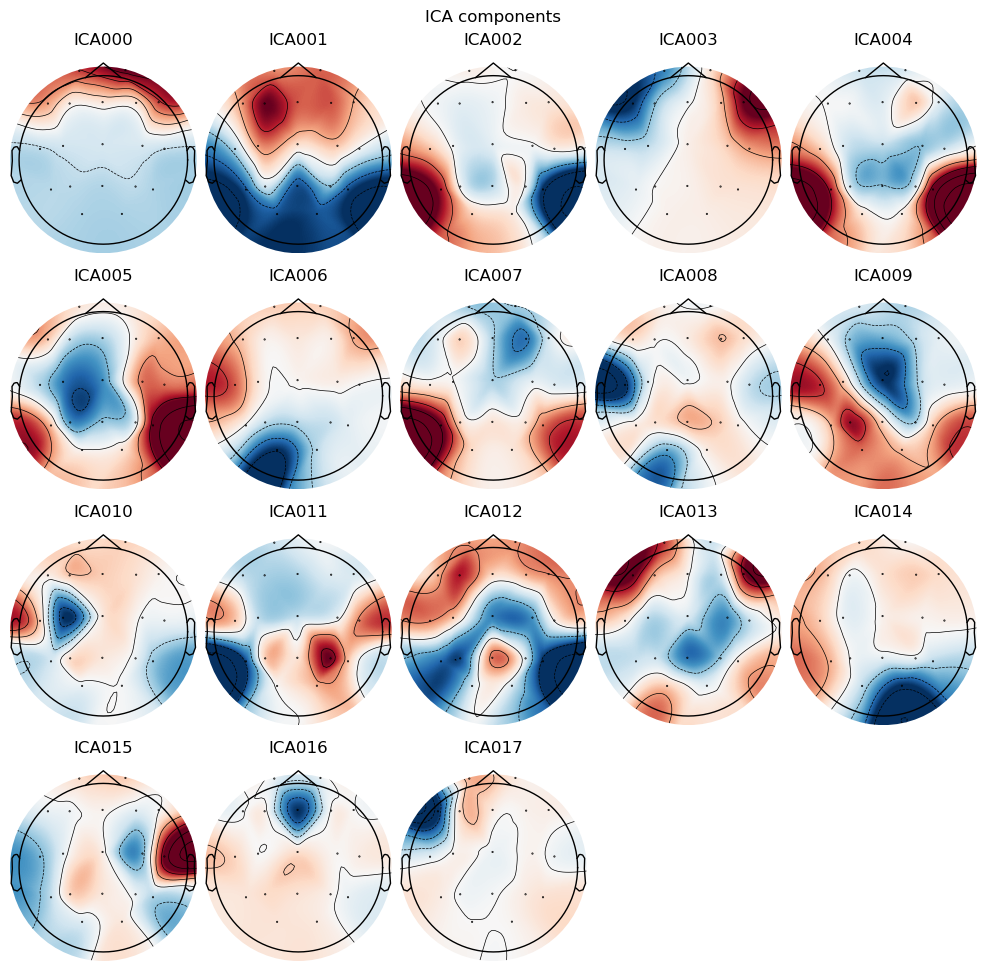

<Figure size 640x480 with 0 Axes>

In [25]:
\
# Run ICA extraction on the AutoReject results
from scr.steps.ica_extraction import ICAExtractionStep

# Configure ICA parameters based on debug mode

    # Full parameters for normal mode
ica_params = {
    "n_components": 18,  # Explain 99% of the variance
    "method": "infomax",   # Infomax algorithm (better for EEG)
    "max_iter": 2000,      # More iterations for better convergence
    "fit_params": {"extended": True},  # Extended Infomax for sub and super-Gaussian sources
    "decim": None             # Temporal decimation factor for faster processing
}

# Set up the ICA extraction parameters
ica_extraction_params = {
    "n_components": ica_params["n_components"],
    "method": ica_params["method"],
    "max_iter": ica_params["max_iter"],
    "fit_params": ica_params["fit_params"],
    "decim": ica_params["decim"],
    "use_good_epochs_only": True,  # Use only good epochs identified by AutoReject
    "plot_dir": ica_extraction_dir,  # Directory for saving figures
    "plot_components": True,
    "plot_sources": False,
    "plot_properties": False,
    "plot_psd": False,
    "interactive": True,  # No interactive plots in debug mode
    "subject_id": sub_id,
    "session_id": ses_id,
    "run_id": run_id,
    "task_id": task_id,
    "save_data": False,  # Save checkpoint after step
    "store_ica_in_epochs": False,  # Store ICA in epochs.info['temp']
    "paths": paths,  # Add the paths object
}

# Add this cell at the top of your notebook
%matplotlib inline
import matplotlib.pyplot as plt

# When configuring the ICA parameters, set interactive to False
ica_extraction_params = {
    "n_components": ica_params["n_components"],
    "method": ica_params["method"],
    "max_iter": ica_params["max_iter"],
    "fit_params": ica_params["fit_params"],
    "decim": ica_params["decim"],
    "use_good_epochs_only": True,
    "plot_dir": ica_extraction_dir,
    "plot_components": True,
    "plot_sources": False,  # You can enable this now
    "plot_properties": False,  # You can enable this now
    "plot_psd": False,  # You can enable this now
    "interactive": False,  # Change this to False for notebook display
    "subject_id": sub_id,
    "session_id": ses_id,
    "run_id": run_id,
    "task_id": task_id,
    "save_data": False,
    "store_ica_in_epochs": True,
    "paths": paths,
}

# Remove this line as we're using inline backend
# matplotlib.use('Qt5Agg')  # Remove or comment out this line

# After running ICA extraction, you can manually display the figures
ica_extraction_step = ICAExtractionStep(params=ica_extraction_params)
if epochs_with_ar is not None:
    print(f"Data shape before ICA extraction: {epochs_with_ar.get_data().shape}")
    epochs_with_ica = ica_extraction_step.run(epochs_with_ar)
    
    # Display ICA figures (if they weren't automatically displayed)
    if hasattr(ica_extraction_step, 'figures') and ica_extraction_step.figures:
        for fig in ica_extraction_step.figures[:5]:  # Limit to first 5 figures
            plt.figure(fig.number)
            plt.show()


## Step 4: ICA Labeling and Artifact Removal

In this step, we'll identify and remove ICA components related to artifacts (eye movements, muscle activity, heartbeat).

2025-04-14 21:21:52,641 - root - INFO - [ICALabelingStep] Jupyter environment detected, using inline backend
2025-04-14 21:21:52,643 - root - INFO - [ICALabelingStep] Retrieved ICA from data.info['temp']
2025-04-14 21:21:52,645 - root - INFO - [ICALabelingStep] Saving plots to D:\Yann\neurotheque_resources\reports\intermediate\ica\01\001\task-gng\run-01
2025-04-14 21:21:52,646 - root - INFO - [ICALabelingStep] Labeling components by correlation with EOG/ECG


[ICALabelingStep] Plots will be saved to: D:\Yann\neurotheque_resources\reports\intermediate\ica\01\001\task-gng\run-01
Using EOG channels: Fp1, Fp2


2025-04-14 21:21:53,128 - root - INFO - [ICALabelingStep] Identified EOG components: [np.int64(0), np.int64(13), np.int64(3), np.int64(7), np.int64(1), np.int64(4), np.int64(14), np.int64(12), np.int64(10), np.int64(6), np.int64(9), np.int64(11), np.int64(17), np.int64(2), np.int64(8), np.int64(15), np.int64(16)]
2025-04-14 21:21:53,129 - root - INFO - [ICALabelingStep] Component 0 identified as EOG with score 0.96
2025-04-14 21:21:53,130 - root - INFO - [ICALabelingStep] Plotting labeled components


[ICALabelingStep] Saving plots to: D:\Yann\neurotheque_resources\reports\intermediate\ica\01\001\task-gng\run-01\labeled_components


2025-04-14 21:21:53,508 - root - INFO - [ICALabelingStep] Saved overview plot to D:\Yann\neurotheque_resources\reports\intermediate\ica\01\001\task-gng\run-01\labeled_components\overview.png


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
396 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
396 matching events found
No baseline correction applied
0 projection items activated


2025-04-14 21:21:54,751 - root - ERROR - [ICALabelingStep] Error plotting properties for component 0: 'list' object has no attribute 'savefig'
2025-04-14 21:21:54,752 - root - INFO - [ICALabelingStep] Automatically excluding components: [np.int64(0)]
2025-04-14 21:21:54,753 - root - INFO - [ICALabelingStep] Excluding components: [np.int64(0)]


Applying ICA to Epochs instance
    Transforming to ICA space (18 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components


d:\Yann\neurotheque_resources\scr\steps\ica_labeling.py:331: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  # Create standardized file paths
2025-04-14 21:21:54,882 - root - INFO - [ICALabelingStep] Plotting data before and after ICA cleaning


[ICALabelingStep] Saving before/after plots to: D:\Yann\neurotheque_resources\reports\intermediate\ica\01\001\task-gng\run-01\before_after


d:\Yann\neurotheque_resources\scr\steps\ica_labeling.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.show()
2025-04-14 21:21:56,447 - root - INFO - [ICALabelingStep] Saved raw before/after plot to D:\Yann\neurotheque_resources\reports\intermediate\ica\01\001\task-gng\run-01\before_after\raw_before_after.png
2025-04-14 21:21:56,469 - root - ERROR - [ICALabelingStep] Error in _plot_before_after: No mne.time_frequency attribute psd_welch


Opening folder: D:\Yann\neurotheque_resources\reports\intermediate\ica\01\001\task-gng\run-01


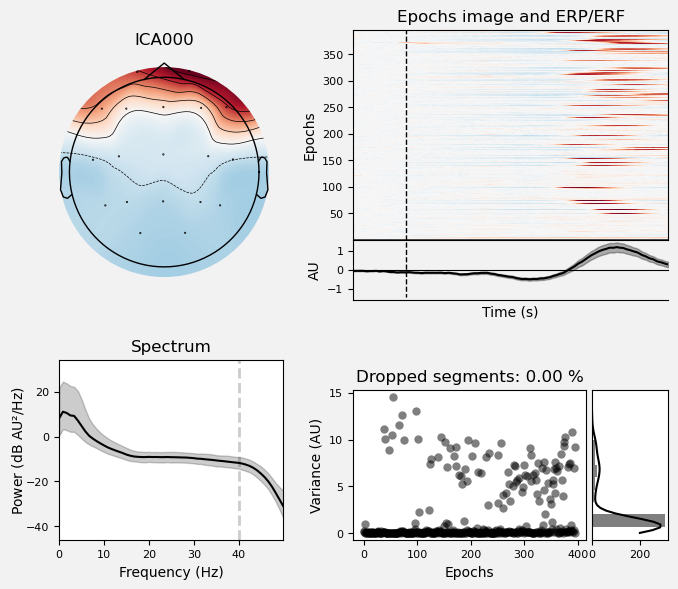

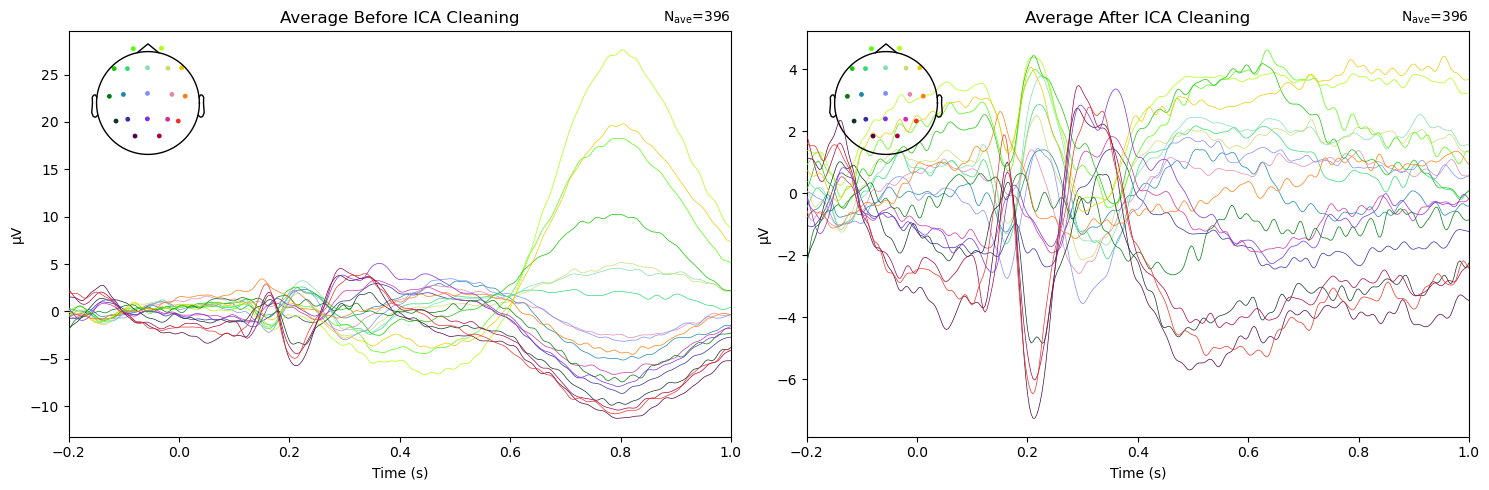

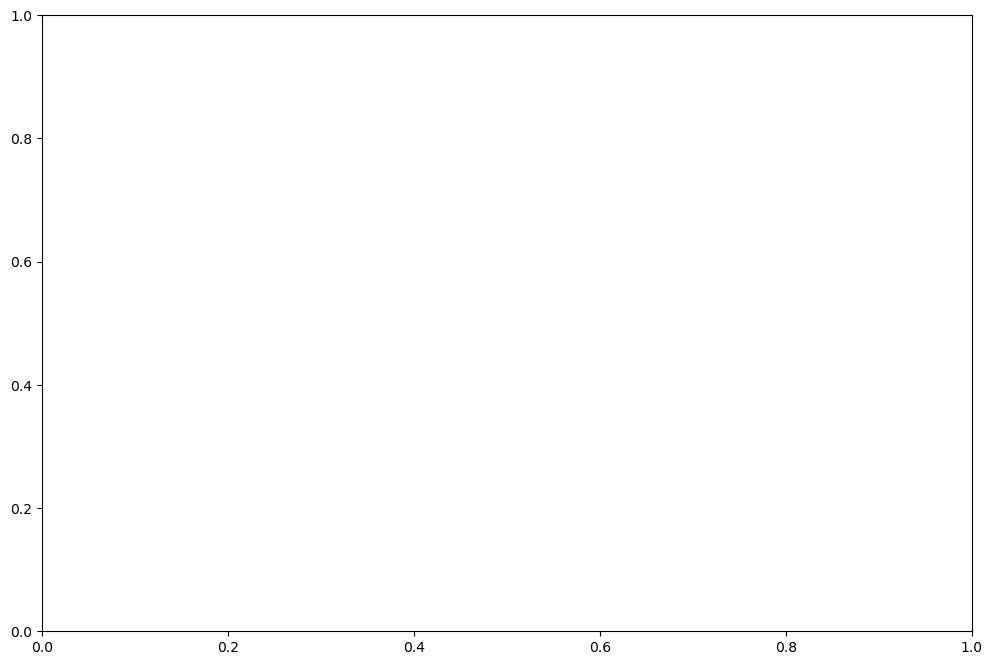

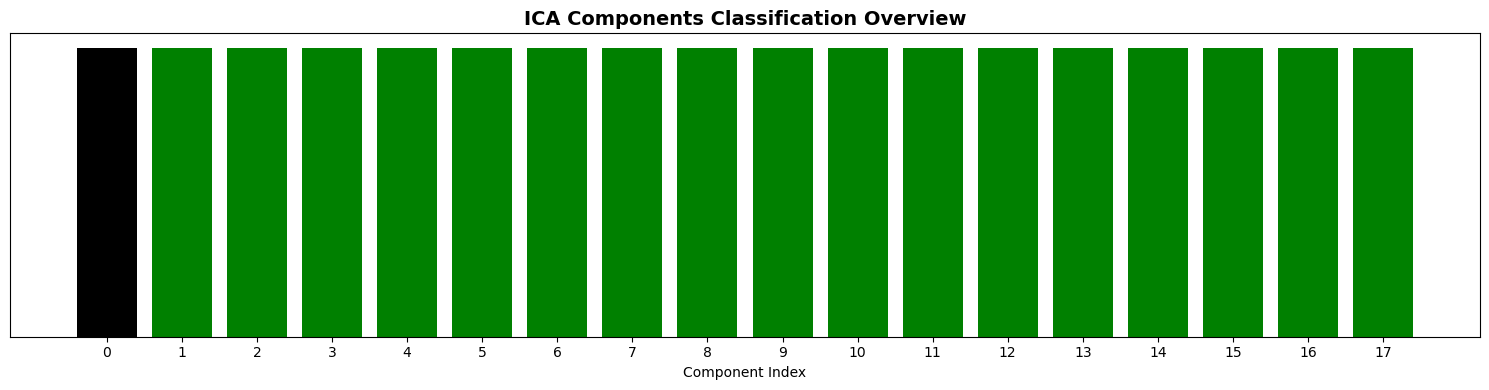

<Figure size 640x480 with 0 Axes>

In [31]:

# Import the ICA labeling step
from scr.steps.ica_labeling import ICALabelingStep

# Set up thresholds for component classification
thresholds = {
    "iclabel": {
        "eye": 0.8,       # High threshold for eye artifacts
        "heart": 0.8,     # High threshold for heart artifacts
        "muscle": 0.8,    # High threshold for muscle artifacts
        "line_noise": 0.8,
        "channel_noise": 0.8,
        "other": 0.8
    },
    "correlation": {
        "eog": 0.5,
        "ecg": 0.3
    }
}

# Add this at the top of your notebook
%matplotlib inline
import matplotlib.pyplot as plt

# When configuring the ICA labeling parameters, set interactive to False
ica_labeling_params = {
    "methods": ['correlation'],
    "thresholds": thresholds,
    "eog_ch_names": ["Fp1", "Fp2"],
    "ecg_channel": None,
    "manual_selection": False,
    "plot_labeled": True,
    "plot_before_after": True,  # You can enable this now
    "interactive": False,  # Change to False for notebook display
    "plot_dir": ica_labeling_dir,
    "reconstruct": True,
    "auto_exclude": True,
    "subject_id": sub_id,
    "session_id": ses_id,
    "run_id": run_id,
    "task_id": task_id,
    "save_data": False,
    "output_file": None,
    "paths": paths,
}

# Then run your ICA labeling step
ica_labeling_step = ICALabelingStep(params=ica_labeling_params)
cleaned_epochs = ica_labeling_step.run(epochs_with_ica)

# If you want to display specific figures from the collected figures:
if hasattr(ica_labeling_step, 'figures') and ica_labeling_step.figures:
    for fig in ica_labeling_step.figures[:3]:  # Display the first 3 figures
        plt.figure(fig.number)
        plt.show()



## Step 5: Second AutoReject Pass

Now we'll apply a second AutoReject pass to the ICA-cleaned data to identify and handle any remaining bad epochs.

In [ ]:
# Define checkpoint file path for final AutoReject
final_ar_checkpoint_file = os.path.join(
    processed_dir, 
    f"sub-{sub_id}", 
    f"ses-{ses_id}",
    f"sub-{sub_id}_ses-{ses_id}_task-{task_id}_run-{run_id}_ar_final_pass_epo.fif"
)

# Check if final AutoReject file already exists
if os.path.exists(final_ar_checkpoint_file):
    logger.info(f"Found existing final AutoReject checkpoint at {final_ar_checkpoint_file}")
    logger.info("Loading final AutoReject results instead of recomputing...")
    try:
        final_epochs = mne.read_epochs(final_ar_checkpoint_file, preload=True)
        print(f"Successfully loaded final AutoReject epochs with {len(final_epochs)} epochs")
    except Exception as e:
        logger.error(f"Error loading final AutoReject checkpoint file, will recompute: {e}")
        try:
            os.remove(final_ar_checkpoint_file)
            logger.info(f"Deleted corrupted final AutoReject checkpoint file: {final_ar_checkpoint_file}")
        except Exception as delete_error:
            logger.warning(f"Could not delete corrupted file: {delete_error}")
        need_final_ar = True
    else:
        need_final_ar = False
else:
    need_final_ar = True

if need_final_ar:
    # Apply the second AutoReject pass
    from scr.steps.autoreject import AutoRejectStep
    
    # Configure AutoReject parameters based on debug mode
    if debug_mode:
        # Parameters for debug mode (faster, less precise)
        ar_debug = config.get('debug_mode', {}).get('autoreject', {})
        n_interpolate = ar_debug.get("n_interpolate", [1])
        consensus = ar_debug.get("consensus", [0.5])
        n_jobs = ar_debug.get("n_jobs", 1)
        
        final_ar_params_dict = {
            "n_interpolate": n_interpolate if isinstance(n_interpolate, list) else [n_interpolate],
            "consensus": consensus if isinstance(consensus, list) else [consensus],
            "n_jobs": n_jobs,
            "verbose": ar_debug.get("verbose", 'tqdm')
        }
    else:
        # Standard parameters for full processing
        final_ar_params_dict = {
            "n_interpolate": [1, 4, 8],  # More precise grid search
            "consensus": [0.1, 0.3, 0.5, 0.75, 0.95],  # More precise grid search
            "thresh_method": "bayesian_optimization",
            "n_jobs": 1,
        }
    
    # Set up the final AutoReject step parameters
    autoreject_final_params = {
        "ar_params": final_ar_params_dict,
        "plot_results": not debug_mode,  # Show plots only in non-debug mode
        "interactive": not debug_mode,   # Show interactive plots only in non-debug mode
        "mode": "fit_transform",         # Clean and keep only good epochs
        "file_prefix": "ar_final_pass",
        "output_dir": os.path.join(processed_dir, "autoreject"),
        "plot_dir": autoreject_dir,      # Directory for saving figures
        "store_reject_log": True,
        "save_model": True,              # Save the model state for future use
        "subject_id": sub_id,
        "session_id": ses_id,
        "run_id": run_id,
        "save_cleaned_data": True,       # Save the data for checkpoint
        "paths": paths,                  # Add the paths object
    }
    
    # Create and run the final AutoReject step
    logger.info("Applying second AutoReject pass on ICA-cleaned data")
    
    if 'cleaned_epochs' in locals() and cleaned_epochs is not None:
        print(f"Data shape before final AutoReject: {cleaned_epochs.get_data().shape} (epochs x channels x time points)")
        autoreject_final_step = AutoRejectStep(params=autoreject_final_params)
        final_epochs = autoreject_final_step.run(cleaned_epochs)
        
        # Log results
        if final_epochs is not None:
            print(f"Data shape after final AutoReject: {final_epochs.get_data().shape} (epochs x channels x time points)")
            if cleaned_epochs is not None:
                print(f"Final AutoReject removed {len(cleaned_epochs) - len(final_epochs)} out of {len(cleaned_epochs)} epochs ({(len(cleaned_epochs) - len(final_epochs))/len(cleaned_epochs)*100:.1f}%)")
        else:
            logger.warning("Final AutoReject returned None instead of epochs")
    else:
        logger.error("Cannot run final AutoReject because ICA labeling returned None or wasn't performed")

## Step 6: Saving the Final Cleaned Epochs

Finally, we'll save the fully cleaned epochs for further analysis.

In [ ]:
# Create output directory and file path
output_dir = os.path.join(processed_dir, f"sub-{sub_id}", f"ses-{ses_id}")
output_file = os.path.join(output_dir, f"sub-{sub_id}_ses-{ses_id}_task-{task_id}_run-{run_id}_intermediate-cleaned_epo.fif")
os.makedirs(output_dir, exist_ok=True)

if 'final_epochs' in locals() and final_epochs is not None:
    try:
        # Create a copy to avoid modifying the original
        final_epochs_clean = final_epochs.copy()
        
        # Store events and event_id separately to make sure they're preserved
        events = final_epochs_clean.events
        event_id = final_epochs_clean.event_id
        
        # Remove ICA object from info['temp'] to prevent serialization issues
        if 'temp' in final_epochs_clean.info:
            if 'ica' in final_epochs_clean.info['temp']:
                logger.info("Removing ICA object from info['temp'] to prevent serialization issues")
                del final_epochs_clean.info['temp']['ica']
        
        # Log what we're saving
        print(f"Saving final cleaned epochs to: {output_file}")
        print(f"Data shape: {final_epochs_clean.get_data().shape}")
        print(f"Events shape: {events.shape}")
        print(f"Event IDs: {event_id}")
        print(f"Channel names: {final_epochs_clean.ch_names}")
        
        # Clean the epochs object to ensure it can be serialized
        from scr.utils.mne_utils import clean_mne_object
        final_epochs_clean = clean_mne_object(final_epochs_clean)
        
        # Save the epochs
        final_epochs_clean.save(output_file, overwrite=True)
        print(f"Successfully saved final cleaned epochs to {output_file}")
        
        # Verify saved file has events
        try:
            test_load = mne.read_epochs(output_file)
            print(f"Verification: Loaded saved file with {len(test_load)} epochs and {len(test_load.event_id)} event types")
            print(f"Verification: Event IDs in saved file: {test_load.event_id}")
        except Exception as e:
            logger.warning(f"Could not verify saved file: {e}")
    except Exception as e:
        logger.error(f"Error saving final cleaned epochs: {e}")
else:
    logger.error("No final epochs available to save")

## Step 7: Generate Summary Visualizations

Finally, let's create some summary plots to visualize the cleaned ERP data.

In [ ]:
if 'final_epochs' in locals() and final_epochs is not None:
    # Import ERPVisualizer
    from scr.analysis.erp_visualization import ERPVisualizer
    
    # Initialize the visualizer with final epochs and output directory
    erp_viz = ERPVisualizer(
        epochs=final_epochs,
        output_dir=summary_dir,
        subject_id=sub_id,
        session_id=ses_id,
        run_id=run_id,
        task_id=task_id
    )
    
    logger.info("Creating ERP visualizations...")
    
    # 1. Basic ERP comparison for Go/NoGo conditions
    fig = erp_viz.plot_erps_comparison(
        conditions=['correct_go', 'correct_nogo'],
        colors=['b', 'r'],
        title="Go vs NoGo - Grand Average ERPs",
        show=True,
        save=True,
        filename=f"sub-{sub_id}_ses-{ses_id}_go_nogo_erps.png",
        baseline=(None, 0)
    )
    
    # 2. Plot topographic maps at key time points
    topo_figs = erp_viz.plot_topo_maps(
        conditions=['correct_go', 'correct_nogo'],
        times=[0.1, 0.2, 0.3, 0.4, 0.5],  # N1, P2, P3 typical latencies
        show=True,
        save=True,
        baseline=(None, 0)
    )
    
    # 3. Plot difference wave (NoGo - Go)
    diff_fig = erp_viz.plot_difference_wave(
        condition1='correct_nogo',
        condition2='correct_go',
        title="NoGo - Go Difference Wave",
        show=True,
        save=True,
        baseline=(None, 0)
    )
    
    # 4. Butterfly plots for each condition
    butterfly_figs = erp_viz.plot_butterfly(
        conditions=['correct_go', 'correct_nogo'],
        title="All Channels ERP",
        show=True,
        save=True,
        baseline=(None, 0)
    )
    
    # 5. Channel-specific ERPs for midline electrodes
    for channel in ['Fz', 'Cz', 'Pz']:
        if channel in final_epochs.ch_names:
            channel_fig = erp_viz.plot_channel_erps(
                conditions=['correct_go', 'correct_nogo'],
                channel=channel,
                colors=['b', 'r'],
                title=f"{channel} - Go/NoGo ERPs",
                show=True,
                save=True,
                baseline=(None, 0)
            )
        else:
            logger.info(f"Channel {channel} not found in data, skipping channel-specific plot")
    
    # Handle missing condition names by finding available conditions
    avail_conditions = list(final_epochs.event_id.keys()) if hasattr(final_epochs, 'event_id') else []
    if avail_conditions and len(avail_conditions) >= 2 and 'correct_go' not in avail_conditions:
        logger.info(f"'correct_go' and 'correct_nogo' not found. Using available conditions: {avail_conditions}")
        # Use the first two conditions for visualization
        cond1, cond2 = avail_conditions[:2]
        
        # Rerun key plots with available conditions
        fig = erp_viz.plot_erps_comparison(
            conditions=[cond1, cond2],
            colors=['b', 'r'],
            title=f"{cond1} vs {cond2} - Grand Average ERPs",
            show=True,
            save=True,
            filename=f"sub-{sub_id}_ses-{ses_id}_condition_comparison_erps.png",
            baseline=(None, 0)
        )
        
    logger.info("Completed all ERP visualizations")
else:
    logger.warning("No final epochs available for visualization")

## Summary

In this notebook, we've implemented the intermediate preprocessing pipeline for Go/No-Go task data. The pipeline applies more advanced artifact correction techniques compared to the minimal pipeline, including:

1. **First AutoReject Pass** to identify and remove bad epochs
2. **ICA Extraction** to separate brain signals from artifacts
3. **ICA Labeling** to identify and remove artifact components
4. **Second AutoReject Pass** to clean the data after ICA

The final cleaned epochs are saved and can be used for further analysis. The pipeline also generates various visualizations to help assess the quality of the preprocessing and explore the ERPs.